# Control

Convex optimization can be used to solve many problems that arise in control.
In this example we show how to solve such a problem using CVXPY.
We have a system with a state $x_t\in {\bf R}^n$ that varies over the time steps $t=0,\ldots,T$, and inputs or actions $u_t\in {\bf R}^m$ we can use at each time step to affect the state.
For example, $x_t$ might be the position and velocity of a rocket and $u_t$ the output of the rocket's thrusters.
We model the evolution of the state as a linear dynamical system, i.e.,

$$ x_{t+1} = Ax_t + Bu_t $$

where $A \in {\bf R}^{n\times n}$ and $B \in {\bf R}^{n\times m}$ are known matrices.

Our goal is to find the optimal actions $u_0,\ldots,u_{T-1}$ by solving the optimization problems

\begin{array}{ll} \mbox{minimize} & \sum_{t=0}^{T-1} \ell (x_t,u_t) + \ell_T(x_T)\\
\mbox{subject to} & x_{t+1} = Ax_t + Bu_t\\%, \quad t=0, \ldots, T-1\\
& (x_t,u_t) \in \mathcal C, \quad x_T\in \mathcal C_T,
%, \quad \quad t=0, \ldots, T
\end{array}

where $\ell: {\bf R}^n \times {\bf R}^m\to {\bf R}$ is the stage cost, $\ell_T$ is the terminal cost,
$\mathcal C$ is the state/action constraints, and $\mathcal C_T$ is the terminal constraint.
The optimization problem is convex if the costs and constraints are convex.


### Example

In the following code we solve a control problem with $n=8$ states, $m=2$ inputs, and horizon $T=50$.
The matrices $A$ and $B$ and the initial state $x_0$ are randomly chosen (with $A\approx I$).
We use the (traditional) stage cost $\ell(x,u) = \|x\|_2^2 + \|u\|_2^2$, the input constraint $\|u_t\|_\infty \leq 1$, and the terminal constraint $x_{T}=0$.

In [1]:
# Generate data for control problem.
import numpy as np

np.random.seed(1)
n = 8
m = 2
T = 50
alpha = 0.2
beta = 3
A = np.eye(n) - alpha * np.random.rand(n, n)
B = np.random.randn(n, m)
x_0 = beta * np.random.randn(n)

In [2]:
# Form and solve control problem.
import cvxpy as cp


x = cp.Variable((n, T + 1))
u = cp.Variable((m, T))

cost = 0
constr = []
for t in range(T):
    cost += cp.sum_squares(x[:, t + 1]) + cp.sum_squares(u[:, t])
    constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t], cp.norm(u[:, t], "inf") <= 1]
# sums problem objectives and concatenates constraints.
constr += [x[:, T] == 0, x[:, 0] == x_0]
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve()

2515.656065442021

We display the results below as a $4$-high stack of plots showing $u_1$, $u_2$, $x_1$, and $x_2$ vs $t$.
Notice that $u_t$ is saturated (i.e., $\|u_t\|_\infty = 1$) initially, which shows that the input constraint is meaningful.

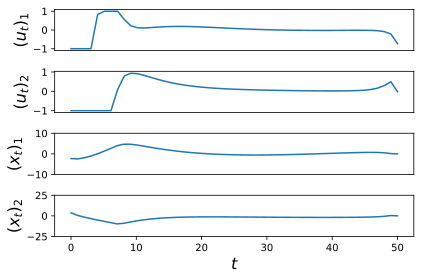

In [3]:
# Plot results.
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(u[0, :].value)
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4, 1, 2)
plt.plot(u[1, :].value)
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# Plot (x_t)_1.
plt.subplot(4, 1, 3)
x1 = x[0, :].value
plt.plot(x1)
plt.ylabel(r"$(x_t)_1$", fontsize=16)
plt.yticks([-10, 0, 10])
plt.ylim([-10, 10])
plt.xticks([])

# Plot (x_t)_2.
plt.subplot(4, 1, 4)
x2 = x[1, :].value
plt.plot(range(51), x2)
plt.yticks([-25, 0, 25])
plt.ylim([-25, 25])
plt.ylabel(r"$(x_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()